In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import xgboost as xgb
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')

import re
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# --- Utility Functions ---

def clean_data(data):
    newData = []
    for text in data:
        text = re.sub(r'\[.*?\]', '', text)
        newData.append(text)
    data = newData
    newData = []
    for text in data:
        text = text.lower()
        for ch in "\n.,?:!()[]{}-+\\/|&%\"~'":
            text = text.replace(ch, ' ')
        newData.append(text)
    return newData

def split_data(data):
    return [text.split() for text in data]

def stem(data):
    stemmer = SnowballStemmer("english")
    return [[stemmer.stem(word) for word in text] for text in data]

def remove_stopwords(data):
    stopWords = set(stopwords.words('english'))
    return [[word for word in text if word not in stopWords] for text in data]

def create_vocab(data, threshhold=None):
    vocabSizes = {}
    for text in data:
        for word in text:
            vocabSizes[word] = vocabSizes.get(word, 0) + 1
    vocabTopWords = {}
    for i, word in enumerate(sorted(vocabSizes, key=vocabSizes.get, reverse=True)):
        vocabTopWords[word] = i
        if threshhold is not None and i >= threshhold-1:
            break
    return vocabTopWords

genre_to_class = {'Pop':0, 'Rock':1, 'Country':2, 'Electronic':3, 'Hip-Hop':4}


In [ ]:
train = pd.read_csv('/content/drive/My Drive/musicGenrePrediction/train.csv')
test = pd.read_csv('/content/drive/My Drive/musicGenrePrediction/test.csv')


In [ ]:
# --- Step 1: Data Preparation ---

print("Loading and preparing data...")
# Load raw datasets
# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')

# Combine and deduplicate
data = pd.concat([train, test]).drop_duplicates().reset_index(drop=True)

# Filter five genres
genres = ['Pop', 'Rock', 'Country', 'Electronic', 'Hip-Hop']
data = data[data['Genre'].isin(genres)]

# Clean lyrics
data['Lyrics'] = data['Lyrics'].astype(str)
data['Lyrics'] = clean_data(data['Lyrics'])
data = data[data['Lyrics'].str.strip().astype(bool)]

# Tokenize, remove stopwords, stem
data['Lyrics'] = split_data(data['Lyrics'])
stop_words = set(stopwords.words('english'))
data['Lyrics'] = [ [w for w in text if w not in stop_words] for text in data['Lyrics'] ]
data['Lyrics'] = stem(data['Lyrics'])

# Balance classes by duplicating smaller ones
min_count = data['Genre'].value_counts().min()
balanced_data = []
for g in genres:
    subset = data[data['Genre'] == g]
    if len(subset) < 2*min_count:
        subset = pd.concat([subset, subset])
    balanced_data.append(subset.sample(n=2*min_count, random_state=42))
data_balanced = pd.concat(balanced_data).sample(frac=1, random_state=42).reset_index(drop=True)

# Save cleaned balanced data
data_balanced.to_csv('clean_data.csv', index=False)
print("Data preparation complete. Saved as 'clean_data.csv'.")


In [ ]:
# --- Step 2: Load cleaned data for model training ---

print("Loading cleaned data...")
data = pd.read_csv('/content/drive/My Drive/musicGenrePrediction/clean_data.csv')
data['Lyrics'] = data['Lyrics'].apply(eval)

X = data['Lyrics']
y = data['Genre'].map(genre_to_class)

# Split into train, val, test (stratified)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


Loading cleaned data...


Building TF-IDF vocabulary and features...
Training DNN model...
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.3283 - loss: 1.4989 - val_accuracy: 0.5397 - val_loss: 1.1395
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7160 - loss: 0.8105 - val_accuracy: 0.5789 - val_loss: 1.1418
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8734 - loss: 0.3964 - val_accuracy: 0.5587 - val_loss: 1.4116
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9391 - loss: 0.2055 - val_accuracy: 0.5581 - val_loss: 1.7577
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9765 - loss: 0.0985 - val_accuracy: 0.5445 - val_loss: 2.1025
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9847 - loss: 0.0630 - val_accuracy: 0.5445 - val_loss: 2.3694
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9945 - loss: 0.0310 - val_accuracy: 0.5374 - val_loss: 2.6097
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:40:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Validation accuracy: 0.5836298932384342


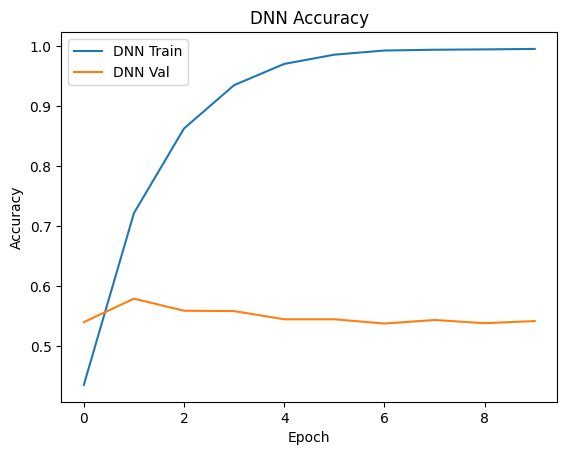

In [ ]:
# --- Step 3: TF-IDF Models (DNN & XGBoost) ---

def create_doc_frequencies(data, vocab):
    num_docs = len(data)
    doc_freq = {}
    for word in vocab:
        doc_freq[word] = sum(1 for doc in data if word in doc) / num_docs
    return doc_freq

def create_tf_idf(data, doc_freq, vocab):
    df_vals = list(doc_freq.values())
    vecs = []
    for doc in data:
        vec = [0]*len(vocab)
        for word in doc:
            if word in vocab:
                vec[vocab[word]] +=1
        for i in range(len(vec)):
            tf = vec[i]/len(doc) if len(doc)>0 else 0
            vec[i] = tf * np.log(1/(df_vals[i]+1e-8))
        vecs.append(vec)
    return np.array(vecs)

print("Building TF-IDF vocabulary and features...")
vocab = create_vocab(X_train, threshhold=10000)
doc_freq = create_doc_frequencies(X_train, vocab)

X_train_tfidf = create_tf_idf(X_train, doc_freq, vocab)
X_val_tfidf = create_tf_idf(X_val, doc_freq, vocab)
X_test_tfidf = create_tf_idf(X_test, doc_freq, vocab)

# y_train = y_train.values
# y_val = y_val.values
# y_test = y_test.values
# Ensure y_train, y_val, y_test are numpy arrays (only convert if they are pandas Series)
if not isinstance(y_train, np.ndarray):
    y_train = y_train.values
if not isinstance(y_val, np.ndarray):
    y_val = y_val.values
if not isinstance(y_test, np.ndarray):
    y_test = y_test.values


def build_dnn(vocab_size):
    inputs = tf.keras.Input(shape=(vocab_size,))
    x1 = tf.keras.layers.Dense(1024, activation='relu')(inputs)
    d1 = tf.keras.layers.Dropout(0.2)(x1)
    x2 = tf.keras.layers.Dense(1024, activation='relu')(d1)
    d2 = tf.keras.layers.Dropout(0.2)(x2)
    concat = tf.keras.layers.Concatenate()([x1,x2,d1,d2])
    outputs = tf.keras.layers.Dense(5, activation='softmax')(concat)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

print("Training DNN model...")
model_dnn = build_dnn(X_train_tfidf.shape[1])
checkpoint_dnn = tf.keras.callbacks.ModelCheckpoint('weights_dnn_best.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)
history_dnn = model_dnn.fit(X_train_tfidf, y_train, epochs=10, batch_size=256, validation_data=(X_val_tfidf, y_val), callbacks=[checkpoint_dnn])
model_dnn.load_weights('weights_dnn_best.weights.h5')
loss, acc = model_dnn.evaluate(X_test_tfidf, y_test)
print("DNN Test accuracy:", acc)

print("Training XGBoost model...")
model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model_xgb.fit(X_train_tfidf, y_train)
print("XGBoost Validation accuracy:", model_xgb.score(X_val_tfidf, y_val))

plt.plot(history_dnn.history['accuracy'], label='DNN Train')
plt.plot(history_dnn.history['val_accuracy'], label='DNN Val')
plt.title('DNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Training RNN model...
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 0.2266 - loss: 1.6056 - val_accuracy: 0.3274 - val_loss: 1.5155
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step - accuracy: 0.3322 - loss: 1.4990 - val_accuracy: 0.3796 - val_loss: 1.4505
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.3964 - loss: 1.3845 - val_accuracy: 0.4057 - val_loss: 1.3422
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.4425 - loss: 1.3100 - val_accuracy: 0.4365 - val_loss: 1.2955
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.5026 - loss: 1.2150 - val_accuracy: 0.4614 - val_loss: 1.2602
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.5387 - loss: 1.1522 - val_accuracy: 0.4798 - val_loss: 1.2393
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.5801 - loss: 1.0577 - val_accuracy: 0.4911 - val_loss: 1.2422
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.6064 - loss: 1.

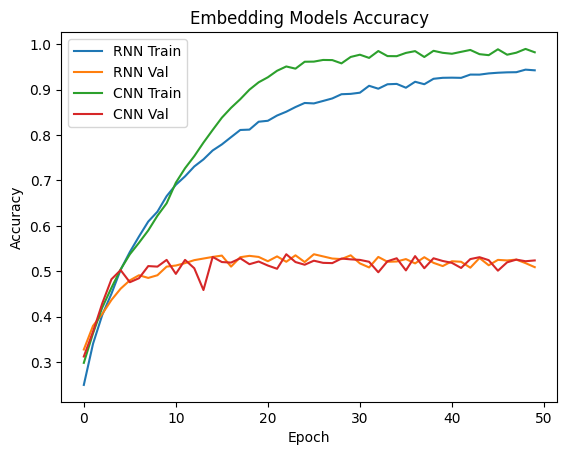

In [ ]:
# --- Step 4: Embedding based models (RNN and CNN) ---

def integer_encoding(data, vocab):
    encoded = []
    for text in data:
        seq = []
        for word in text:
            if word not in vocab:
                seq.append(1)
            elif vocab[word]>0:
                seq.append(vocab[word]+1)
        encoded.append(seq)
    return encoded

X_train_enc = integer_encoding(X_train, vocab)
X_val_enc = integer_encoding(X_val, vocab)
X_test_enc = integer_encoding(X_test, vocab)

max_len = max(len(seq) for seq in X_train_enc)
X_train_pad = pad_sequences(X_train_enc, maxlen=max_len)
X_val_pad = pad_sequences(X_val_enc, maxlen=max_len)
X_test_pad = pad_sequences(X_test_enc, maxlen=max_len)

def build_rnn(vocab_size, max_length):
    inputs = tf.keras.Input(shape=(max_length,))
    x = tf.keras.layers.Embedding(vocab_size+2, 64)(inputs)
    x = tf.keras.layers.LSTM(64)(x)
    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

print("Training RNN model...")
model_rnn = build_rnn(len(vocab), max_len)
checkpoint_rnn = tf.keras.callbacks.ModelCheckpoint('weights_rnn_best.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)
history_rnn = model_rnn.fit(X_train_pad, y_train, epochs=50, batch_size=256, validation_data=(X_val_pad, y_val), callbacks=[checkpoint_rnn])
model_rnn.load_weights('weights_rnn_best.weights.h5')
loss, acc = model_rnn.evaluate(X_test_pad, y_test)
print("RNN Test accuracy:", acc)

def build_cnn(vocab_size, max_length):
    inputs = tf.keras.Input(shape=(max_length,))
    x = tf.keras.layers.Embedding(vocab_size+2, 64)(inputs)
    x = tf.keras.layers.Conv1D(128, 5, activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(5)(x)
    x = tf.keras.layers.Conv1D(128, 5, activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(5)(x)
    x = tf.keras.layers.Conv1D(128, 5, activation='relu')(x)
    x = tf.keras.layers.GlobalMaxPooling1D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

print("Training CNN model...")
model_cnn = build_cnn(len(vocab), max_len)
checkpoint_cnn = tf.keras.callbacks.ModelCheckpoint('weights_cnn_best.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)
history_cnn = model_cnn.fit(X_train_pad, y_train, epochs=50, batch_size=256, validation_data=(X_val_pad, y_val), callbacks=[checkpoint_cnn])
model_cnn.load_weights('weights_cnn_best.weights.h5')
loss, acc = model_cnn.evaluate(X_test_pad, y_test)
print("CNN Test accuracy:", acc)

plt.plot(history_rnn.history['accuracy'], label='RNN Train')
plt.plot(history_rnn.history['val_accuracy'], label='RNN Val')
plt.plot(history_cnn.history['accuracy'], label='CNN Train')
plt.plot(history_cnn.history['val_accuracy'], label='CNN Val')
plt.title('Embedding Models Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# --- Prediction Helpers ---

def predict_genre_dnn(model, songs, vocab, doc_freq):
    # Preprocess input songs just like training
    songs = clean_data(songs)
    songs = split_data(songs)
    songs = stem(songs)
    songs = remove_stopwords(songs)

    def create_tf_idf_single(song):
        vec = [0] * len(vocab)
        doc_freq_vals = list(doc_freq.values())
        for w in song:
            if w in vocab:
                vec[vocab[w]] += 1
        for i in range(len(vec)):
            tf = vec[i] / len(song) if len(song) > 0 else 0
            vec[i] = tf * np.log(1 / (doc_freq_vals[i] + 1e-8))
        return np.array(vec)

    X = np.array([create_tf_idf_single(song) for song in songs])
    preds = model.predict(X)
    return preds

def predict_genre_embedding(model, songs, vocab, max_len):
    songs = clean_data(songs)
    songs = split_data(songs)
    songs = stem(songs)
    songs = remove_stopwords(songs)

    def encode_and_pad(data):
        encoded = []
        for text in data:
            seq = []
            for word in text:
                if word not in vocab:
                    seq.append(1)
                elif vocab[word] > 0:
                    seq.append(vocab[word] + 1)
            encoded.append(seq)
        return pad_sequences(encoded, maxlen=max_len)

    X = encode_and_pad(songs)
    preds = model.predict(X)
    return preds

# --- Genre mapping for printing ---
class_to_genre = {v: k for k, v in genre_to_class.items()}

# Example songs to predict (raw lyrics strings)
example_songs = [
    '''Man, whatever
    Dre, just let it run
    Ayo, turn the beat up a little bit
    ...''',  # partial lyrics of Eminem - The Way I Am
    '''I got sunshine on a cloudy day
    When it's cold outside, I've got the month of May
    ...'''  # partial lyrics for a sample song
]

# Predict and display using DNN (TF-IDF)
print("DNN Model Predictions:")
predictions_dnn = predict_genre_dnn(model_dnn, example_songs, vocab, doc_freq)
for i, probs in enumerate(predictions_dnn):
    pred_class = np.argmax(probs)
    print(f"Song {i+1}: Predicted genre: {class_to_genre[pred_class]} with probabilities {probs}")

# Predict and display using RNN (Embedding)
print("\nRNN Model Predictions:")
predictions_rnn = predict_genre_embedding(model_rnn, example_songs, vocab, max_len)
for i, probs in enumerate(predictions_rnn):
    pred_class = np.argmax(probs)
    print(f"Song {i+1}: Predicted genre: {class_to_genre[pred_class]} with probabilities {probs}")

# Predict and display using CNN (Embedding)
print("\nCNN Model Predictions:")
predictions_cnn = predict_genre_embedding(model_cnn, example_songs, vocab, max_len)
for i, probs in enumerate(predictions_cnn):
    pred_class = np.argmax(probs)
    print(f"Song {i+1}: Predicted genre: {class_to_genre[pred_class]} with probabilities {probs}")


DNN Model Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
Song 1: Predicted genre: Hip-Hop with probabilities [4.6330642e-05 1.6044205e-04 8.1005222e-05 8.5051579e-04 9.9886167e-01]
Song 2: Predicted genre: Country with probabilities [2.0597442e-03 1.8852921e-02 9.7757870e-01 1.3129949e-03 1.9553371e-04]

RNN Model Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
Song 1: Predicted genre: Hip-Hop with probabilities [0.02647257 0.03665416 0.03537459 0.0927311  0.8087676 ]
Song 2: Predicted genre: Hip-Hop with probabilities [0.05003444 0.1656617  0.23703074 0.17228355 0.37498963]

CNN Model Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
Song 1: Predicted genre: Hip-Hop with probabilities [0.09279447 0.16284506 0.07880104 0.26324865 0.4023107 ]
Song 2: Predicted genre: Hip-Hop with probabilities [0.09627274 0.16636182 0.08261152 0.26145202 0.39330193]


In [ ]:
model_dnn.save('/content/drive/MyDrive/my_model_dnn.keras')

model_rnn.save('/content/drive/MyDrive/my_model_rnn.keras')
model_cnn.save('/content/drive/MyDrive/my_model_cnn.keras')
model_xgb.save_model('/content/drive/MyDrive/my_model_xgb.json')






In [ ]:
def clean_and_predict(lyrics):
    # Wrap input into a list as your prediction functions expect list of songs
    songs = [lyrics]

    # DNN Prediction
    dnn_preds = predict_genre_dnn(model_dnn, songs, vocab, doc_freq)
    dnn_pred_class = np.argmax(dnn_preds[0])
    dnn_genre = class_to_genre[dnn_pred_class]

    # RNN Prediction
    rnn_preds = predict_genre_embedding(model_rnn, songs, vocab, max_len)
    rnn_pred_class = np.argmax(rnn_preds[0])
    rnn_genre = class_to_genre[rnn_pred_class]

    # CNN Prediction
    cnn_preds = predict_genre_embedding(model_cnn, songs, vocab, max_len)
    cnn_pred_class = np.argmax(cnn_preds[0])
    cnn_genre = class_to_genre[cnn_pred_class]

    print("\nPredictions for given lyrics:\n")
    print(f"DNN Model Prediction: {dnn_genre} with probabilities {dnn_preds[0]}")
    print(f"RNN Model Prediction: {rnn_genre} with probabilities {rnn_preds[0]}")
    print(f"CNN Model Prediction: {cnn_genre} with probabilities {cnn_preds[0]}")

In [ ]:
# Ask the user to enter the song lyrics
user_lyrics = input("Please enter the song lyrics: ")

# Now predict the genre using your existing prediction function
clean_and_predict(user_lyrics)


Please enter the song lyrics: If you ever find yourself stuck in the middle of the sea I'll sail the world to find you If you ever find yourself lost in the dark and you can't see I'll be the light to guide you  [Pre-Chorus] We find out what we're made of When we are called to help our friends in need  [Chorus] You can count on me like one, two, three, I'll be there And I know when I need it I can count on you like four, three, two and you'll be there 'Cause that's what friends are s'posed to do, oh, yeah  [Post-Chorus] Ooh-ooh-ooh-ooh-ooh Ooh-ooh-ooh-ooh-ooh Ooh, yeah, yeah  [Verse 2] If you're tossin' and you're turnin' and you just can't fall asleep I'll sing a song beside you And if you ever forget how much you really mean to me Everyday, I will remind you, oh [Pre-Chorus] We find out what we're made of When we are called to help our friends in need  [Chorus] You can count on me like one, two, three, I'll be there And I know when I need it I can count on you like four, three, two a

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Predictions for given lyrics:

DNN Model Prediction: Electronic with probabilities [0.18342987 0.01258759 0.04436259 0.6554047  0.1042152 ]
RNN Model Prediction: Pop with probabilities [0.371347  0.0752034 0.0728787 0.2939638 0.1866071]
CNN Model Prediction: Electronic with probabilities [8.73082504e-03 1.13541130e-02 1.04456285e-05 9.79771078e-01
 1.33519905e-04]
